In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_softmax, scatter_add

import torch.optim as optim

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

from torchvision.datasets import MNIST
from torch_geometric.datasets import MNISTSuperpixels

import torch_geometric.transforms as T
from torch_geometric.transforms import BaseTransform

import seaborn as sns

#### transform superpixel graphs

In [2]:
class NodeReorder(BaseTransform):
    """
    Sorts the nodes based on their positions along the y = x line;
    reorders based on projections onto the [1, 1] vector.
    Add positional embeddings and adjacency matrix.
    """
    def __init__(self, unit_vec=None):
        if unit_vec is None:
            self.unit_vec = torch.tensor([1., 1.]) / (2 ** 0.5)  # univec along y = x
        else:
            self.unit_vec = torch.tensor(unit_vec)
        
    def forward(self, data):
        # Compute projections onto the unit vector
        projections = data.pos @ self.unit_vec
        # Get new order by sorting the projections
        new_order = projections.argsort()
        # Create mapping
        mapping = torch.zeros_like(new_order)
        mapping[new_order] = torch.arange(len(new_order), dtype=torch.long)

        # Reorder node features
        if hasattr(data, 'laplacian_eigen_pe'):
            data.x = torch.cat([data.x, data.laplacian_eigen_pe], dim=1)
            del data.laplacian_eigen_pe

        data.x = data.x[new_order]
        data.pos = data.pos[new_order]

        # Update edge indices
        data.edge_index = mapping[data.edge_index]
        
        # Compute adjacency matrix A directly using PyTorch tensors
        num_nodes = data.num_nodes
        edge_index = data.edge_index
        A = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        A[edge_index[0], edge_index[1]] = 1.0
        data.adj = A  # Add adjacency matrix to data

        return data

In [3]:
# laplacian positional embed + node reorder along y = x
transform = T.Compose([
    T.AddLaplacianEigenvectorPE(k=5, attr_name='laplacian_eigen_pe'),
    NodeReorder()
])

mnist_path = '/Users/subat/Desktop/datan/hierarchical gAVE/model dev/mnist_superpixel'
train_transformed = MNISTSuperpixels(root=mnist_path, transform=transform)
test_transformed = MNISTSuperpixels(root=mnist_path, train=False, transform=transform)

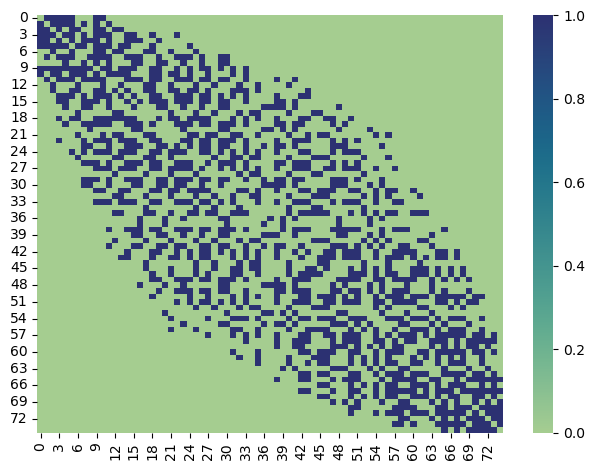

In [4]:
sns.heatmap(train_transformed[0].adj, cmap="crest", cbar=True)
plt.tight_layout()

## hierarchical gvae

In [ ]:
# # element-wise projection of z_A instead of z_A[batch] (z_A_i instead of W_A_i)

#         # s_i = W_h h_i + b_h + W_A z_A + b_A
#         self.W_h = nn.Linear(gcn_hidden_dim, zi_dim)          # W_h: maps h_i to s_i
#         self.W_A = nn.Linear(za_dim, zi_dim, baise=False)   # W_A: maps z_A to s_i
        
#         if self.node_specific_loading:
#             # Node-specific vectors for projecting z_A from [za_dim] to [num_nodes, za_dim]
#             self.W_Ap = nn.Parameter(torch.randn(num_nodes, za_dim))
            
# # forward
#         # ===== 4. Z_i; q(Z_i|Z_A,X,A) =====
#         if self.node_specific_loading:
            
#             # List to hold the projected data
#             z_A_projected = []
#             # For each graph in the batch
#             for i in range(batch_size):
#                 # Project each node through node-specific vectors in W_Ap
#                 transformed = z_A[i].unsqueeze(0) * W_Ap  # element-wise multiplication - node-specific projection of z_A
#                 z_A_projected.append(transformed)
#             z_A_projected = torch.cat(z_A_projected, dim=0)    # [num_nodes, za_dim]
#             # Linear combination: s_i = W_h h_i + W_A z_A_projected 
#             s_i = self.W_h(h) + self.W_A(z_A_projected)        # [num_nodes, zi_dim]
            
#         else: 
#             # Expand z_A to match the number of nodes
#             z_A_expanded = z_A[batch]                          # [num_nodes, za_dim]
#             # Linear combination: s_i = W_h h_i + W_A z_A 
#             s_i = self.W_h(h) + self.W_A(z_A_expanded)         # [num_nodes, zi_dim]

In [32]:
class inference_model(nn.Module):
    def __init__(self, hparams: dict, node_specific_loading: bool = True):
        super(inference_model, self).__init__()
        self.hparams = hparams
        self.node_specific_loading = node_specific_loading

        self.num_nodes_per_graph = hparams['num_nodes_per_graph']   # N        
        self.gcn_hidden_dim = hparams['gcn_hidden_dim']             # Nh
        self.za_dim = hparams['za_dim']                             # G
        self.zi_dim = hparams['zi_dim']                             # F

        # Graph convolutional layers (3-hop)
        self.conv1 = GCNConv(hparams['node_feature_dim'], self.gcn_hidden_dim)
        self.conv2 = GCNConv(self.gcn_hidden_dim, self.gcn_hidden_dim)
        self.conv3 = GCNConv(self.gcn_hidden_dim, self.gcn_hidden_dim)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(self.gcn_hidden_dim)
        self.bn2 = nn.BatchNorm1d(self.gcn_hidden_dim)
        self.bn3 = nn.BatchNorm1d(self.gcn_hidden_dim)
        
        # Attention mechanism to compute attention scores per node
        # φ = φ_1 * h1 + φ_2 * h2 + φ_bias                   [num_nodes,1]
        # attn_weights = softmax(φ)                          [num_nodes,1]
        # φ_weighted = atten_weights * h3                    [num_nodes, gcn_hidden_dim]
        # h_graph = sum(φ_weighted)                          [batch_size, gcn_hidden_dim]
        self.phi_h1 = nn.Linear(self.gcn_hidden_dim, 1)
        self.phi_h2 = nn.Linear(self.gcn_hidden_dim, 1, bias=False)

        # Linear layers to compute μ_A and log Σ_A
        self.fc_mu_A = nn.Linear(self.gcn_hidden_dim, self.za_dim)
        self.fc_logvar_A = nn.Linear(self.gcn_hidden_dim, self.za_dim)
        
        # Linear layers for node-level latent variables s_i (linear combination of h and z_a)
        # s_i = W_h h_i + b_h + W_A z_A + b_A
        self.W_h = nn.Linear(self.gcn_hidden_dim, self.zi_dim)           # W_h: maps h_i to s_i
        
        if self.node_specific_loading:         
            # Node-specific weight matrices for transforming z_A when computing s_i
            # s_i = W_h h_i + b_h + W_A_i z_A + b_A
            self.W_A = nn.Parameter(torch.randn(self.num_nodes_per_graph, self.za_dim, self.zi_dim))
        else:
            self.W_A = nn.Linear(self.za_dim, self.zi_dim, bias=False)   # W_A: maps z_A to s_i
        
        # Linear layers to compute μ_i and log Σ_i
        self.fc_mu_i = nn.Linear(self.zi_dim, self.zi_dim)
        self.fc_logvar_i = nn.Linear(self.zi_dim, self.zi_dim)

    def forward(self, x, edge_index, batch):
        """
        Forward pass through the encoder.

        Args:
            x (Tensor): Node feature matrix of shape [num_nodes, node_feature_dim].
            edge_index (Tensor): Edge indices.

        Returns:
            z_i (Tensor): Sampled node-level latent variables.
            mu_i (Tensor): Mean of the node-level latent variables.
            logvar_i (Tensor): Log variance of the node-level latent variables.
            z_A (Tensor): Sampled graph-level latent variable.
            mu_A (Tensor): Mean of the graph-level latent variable.
            logvar_A (Tensor): Log variance of the graph-level latent variable.
        """      
        # ===== 1. Node hidden states with GCN =====
        h1 = torch.relu(self.bn1(self.conv1(x, edge_index)))
        h2 = torch.relu(self.bn2(self.conv2(h1, edge_index)))
        h3 = torch.relu(self.bn3(self.conv3(h2, edge_index)))  # [num_nodes, gcn_hidden_dim] 
          
        # ===== 2. Attention Pooling to aggregate node-level hidden state to graph-level =====
        # Options: 1) global pooling; 2) hierarchical (local) pooling
        # Review hierarchical pooling, e.g., Self-Attention Graph Pooling (Lee et al., 19')
        # Global pooling implemented below
        
        # Compute attention scores for each node at h1 and h2
        phi = self.phi_h1(h1) + self.phi_h2(h2)                # [num_nodes, 1]
        attn_scores = phi.squeeze(-1)                          # [num_nodes]

        # Compute attention weights using softmax over nodes in the same graph
        attn_weights = scatter_softmax(attn_scores, batch)     # [num_nodes]
        # Weight node embeddings
        attn_weights = attn_weights.unsqueeze(-1)              # [num_nodes, 1]
        phi_weighted = h3 * attn_weights                       # [num_nodes, gcn_hidden_dim]
        # Sum over nodes per graph to get graph-level representation
        h_graph = scatter_add(phi_weighted, batch, dim=0)      # [batch_size, gcn_hidden_dim]
        
        # h_graph = global_mean_pool(h, batch) # simple global mean pooling

        # ===== 3. Z_A; q(Z_A∣X,A) =====
        # Compute μ_A and log Σ_A
        mu_A = self.fc_mu_A(h_graph)            # [batch_size, za_dim] - Mean μ_h
        logvar_A = self.fc_logvar_A(h_graph)    # [batch_size, za_dim] - Log variance log Σ_h
        
        # Reparameterization trick for Z_A
        std_A = torch.exp(0.5 * logvar_A)
        eps_A = torch.randn_like(std_A)
        z_A = mu_A + eps_A * std_A              # [batch_size, za_dim]
        
        # ===== 4. Z_i; q(Z_i|Z_A,X,A) =====
        batch_size = batch.max().item() + 1
        z_A_expanded = z_A[batch]               # [num_nodes, za_dim]
        
        if self.node_specific_loading:
            
            # Reshape z_A to [batch_size, num_nodes_per_graph, za_dim] for batch matrix multiplication
            z_A_reshaped = z_A_expanded.view(batch_size, self.num_nodes_per_graph, self.za_dim).transpose(0, 1)
            # Perform batch matrix multiplication
            # W_A: [num_nodes_per_graph, za_dim, zi_dim]; ngf
            # z_A_reshaped: [num_nodes_per_graph, batch_size, za_dim]; nbg
            # z_A_transformed: [num_nodes_per_graph, batch_size, zi_dim]; nbf
            z_A_transformed = torch.einsum('ngf,nbg->nbf', self.W_A, z_A_reshaped)
            # Reshape to [num_nodes_per_graph * batch_size, zi_dim]
            z_A_transformed = z_A_transformed.transpose(0, 1).reshape(self.num_nodes_per_graph * batch_size, self.zi_dim)
            
            # Linear combination: s_i = W_h h_i + W_A_i z_A
            s_i = self.W_h(h3) + z_A_transformed               # [num_nodes, zi_dim]
            
        else: 
            # Linear combination: s_i = W_h h_i + W_A z_A 
            s_i = self.W_h(h3) + self.W_A(z_A_expanded)        # [num_nodes, zi_dim]
        
        # Compute μ_i and log Σ_i
        mu_i = self.fc_mu_i(s_i)                # [num_nodes, zi_dim]
        logvar_i = self.fc_logvar_i(s_i)        # [num_nodes, zi_dim]
        
        # Reparameterization trick for Z_i
        std_i = torch.exp(0.5 * logvar_i)
        eps_i = torch.randn_like(std_i)
        z_i = mu_i + eps_i * std_i              # [num_nodes, zi_dim]
        
        return z_i, mu_i, logvar_i, z_A, mu_A, logvar_A

In [92]:
class generative_model(nn.Module):
    def __init__(self, hparams: dict):
        super(generative_model, self).__init__()
        self.hparams = hparams

        zi_dim = hparams['zi_dim']                      # F
        node_feature_dim = hparams['node_feature_dim']  # D
        attention_dim = hparams['attention_dim']        # Dimension for Q, K, V 
        self.attention_dim = attention_dim
        
        # Attention layers
        self.query_linear = nn.Linear(zi_dim, attention_dim)
        self.key_linear = nn.Linear(zi_dim, attention_dim)
        self.value_linear = nn.Linear(zi_dim, attention_dim)

        # Node feature decoder (reconstructs X from z_i and A_hat)
        # GCN and MLP?
        # self.node_decoder = 
        
    def adj_decoder(self, z_i, batch):
        """
        Reconstruct adjacency matrices for each graph.

        Args:
            z_i (Tensor): Node-level latent variables [num_nodes, zi_dim].
            batch (Tensor): Batch vector assigning each node to a graph in the batch.

        Returns:
            A_hat_batch (Tensor): Reconstructed adjacency matrices [batch, num_nodes, num_nodes].
        """
        num_graphs = batch.max().item() + 1
        A_hat_list = []

        for i in range(num_graphs):
            mask = (batch == i)
            Z = z_i[mask]                   # [num_nodes_in_graph_i, zi_dim]

            # Compute adjacency matrix reconstruction for each graph
            
            # ===== Attention decoder =====
            # Compute Query, Key, Value
            Q = self.query_linear(Z)        # [num_nodes_in_graph_i, attention_dim]
            K = self.key_linear(Z)          # [num_nodes_in_graph_i, attention_dim]
            V = self.value_linear(Z)        # [num_nodes_in_graph_i, attention_dim]
            
            attention_weights = Q @ K.T                        # [num_nodes_in_graph_i, num_nodes_in_graph_i]
            attention_weights = attention_weights.softmax(1)   # same shape, but attention_weights.sum(1) = ones
            weighted_values = (attention_weights.unsqueeze(-1) * V.unsqueeze(0)).sum(1)   # [num_nodes_in_graph_i, attention_dim]
            Z_att = weighted_values / (self.attention_dim**0.5)
        
            A_hat = torch.sigmoid(torch.matmul(Z_att, Z_att.t()))  # [num_nodes_in_graph_i, num_nodes_in_graph_i]
            
            # Diag(A_hat) is ~ 1, while Diag(A) is 0
            # ***Options - 1) set diag(A_hat) to 0; 2) set diag(A) to 1 for BCE
            A_hat.fill_diagonal_(0) # Option 1
            A_hat_list.append(A_hat)

        return torch.stack(A_hat_list, dim=0)        

    def forward(self, z_i, batch):
        """
        Forward pass through the decoder.

        Args:
            z_i (Tensor): Node-level latent variables [num_nodes, zi_dim].
            batch (Tensor): Batch vector assigning each node to a graph in the batch.

        Returns:
            X_hat (Tensor): Reconstructed node features.
        """
        device = z_i.device
        num_nodes = z_i.size(0)
        num_graphs = batch.max().item() + 1
        
        # Reconstruct A
        A_hat_batch = self.adj_decoder(z_i, batch)

        # Initialize reconstructed node features
        X_hat = torch.zeros((num_nodes, self.hparams['node_feature_dim']), device=device)
        
#         # Process each graph individually
#         for i in range(num_graphs):
#             # Nodes belonging to graph i
#             mask = (batch == i)
#             node_indices = torch.where(mask)[0]
#             num_nodes_in_graph = mask.sum().item()

#             # Extract z_i for graph i
#             z_i_graph = z_i[mask]  # [num_nodes_in_graph, zi_dim]

#             # Get reconstructed adjacency matrix A_hat for graph i
#             A_hat = A_hat_batch[i]  # [num_nodes_in_graph, num_nodes_in_graph]

#             # Convert dense matrix to edge_index and edge_weight
#             edge_index, edge_weight = dense_to_sparse(A_hat)

#             # GCN and MLP layers ?
#             X_hat_graph = self.node_decoder(z_i_graph, edge_index, edge_weight)
#             X_hat[mask] = X_hat_graph
        
        return A_hat_batch, X_hat

In [106]:
class GraphVAELoss(nn.Module):
    """
    Computes the loss function for the HierarchicalGVAE.

    method args:
        A_hat_batch (Tensor): Reconstructed adjacency matrices [batch, num_nodes, num_nodes].
        # X_hat (Tensor): Reconstructed node features [num_nodes, node_feature_dim].
        data (Batch): Original data batch containing edge_index, x, and batch attributes.
        mu_A (Tensor): Mean of z_A [batch_size, za_dim].
        logvar_A (Tensor): Log variance of of z_A [batch_size, za_dim].
        mu_i (Tensor): Mean of z_i [num_nodes, zi_dim].
        logvar_i (Tensor): Log variance of z_i [num_nodes, zi_dim].
        device (torch.device): CPU/GPU.

    method returns:
        total_loss (Tensor): Total loss for the batch.
        adj_recon_term (Tensor): Reconstruction loss for adjacency matrices.
        # node_feature_recon_term (Tensor): Reconstruction loss for node features.
        kl_za_term (Tensor): KL divergence loss for graph-level latent variables.
        kl_zi_term (Tensor): KL divergence loss for node-level latent variables.
    """
    
    def __init__(self, 
                 device: torch.device, 
                 sparsity_weight: float = 1.0, 
                 beta_A: float = 1.0, 
                 beta_i: float = 1.0
                ):
        assert 0.0 < sparsity_weight <= 1.0
        self.sparsity_weight = sparsity_weight
        self.beta_A = beta_A
        self.beta_i = beta_i
        self.device = device
        super(GraphVAELoss, self).__init__()
        
    @staticmethod
    def kl_between_two_gaussians(m1, logvar1, m2, logvar2):
        """
        KL[ N(m1, logvar1) || N(m2, logvar2) ]
            i.e. both distributions parameterised by log of diagonal of covariance matrix
                 
        Shapes:
            m1: [batch, dim]
            logvar1: [batch, dim]
            m2: [batch, dim]
            logvar2: [batch, dim]
            
        Output: [batch], all elements > 0.0
        """
        det1 = logvar1.sum(-1).exp()   # [batch]
        det2 = logvar2.sum(-1).exp()   # [batch]
        det_term = det1 / det2         # [batch]
        
        d_term = m1.shape[1]
        
        trace_term = (logvar1 - logvar2).exp().sum(-1)   # [batch]
        
        mean_diff = m2 - m1
        inner_prod_term = (mean_diff.square() / logvar2.exp()).sum(-1) # [batch]
        
        return 0.5 * det_term - d_term + trace_term + inner_prod_term    
    
    def kl_zi_term(self, mu_i, logvar_i, z_a, all_B_mus, all_B_logvars):
        """
        Inputs:
            mu_i: [batch, num_nodes, dim_zi]
            logvar_i: [batch, num_nodes, dim_zi]
            z_a: [batch, dim_za]
            all_B_mus: [num_nodes, dim_zi, dim_za]
            all_B_logvars: [num_nodes, dim_zi, dim_za]
        
        Sum of each KL to node-wise prior:
            Sum_i KL[ N(mu_i, logvar) || N(...) ]
        """
        z_a = z_a.detach()
        N = all_B_logvars.shape[0]
        
        all_prior_means = torch.einsum('nfg,bg->bnf', all_B_mus, z_a).detach()         # [batch, num_nodes, dim_zi]
        all_prior_logvars = torch.einsum('nfg,bg->bnf', all_B_logvars, z_a).detach()   # [batch, num_nodes, dim_zi]
        
        cumulative_kls = 0.0  # [batch]
        
        for node_index in range(N):
            prior_mean = all_prior_means[:,node_index]      # [batch, dim_zi]
            prior_logvar = all_prior_logvars[:,node_index]  # [batch, dim_zi]
            node_kl = self.kl_between_two_gaussians(
                mu_i[:,node_index], logvar_i[:,node_index],
                prior_mean, prior_logvar)    # [batch]
            cumulative_kls = cumulative_kls + node_kl
            
        return cumulative_kls.mean()   # scalar

    def kl_za_term(self, mu_A, logvar_A):
        """
        Inputs:
            mu_A: [batch, dim_za]
            logvar_A: [batch, dim_za]
        
        KL to prior:
            KL[ N(mu, logvar) || N(O,I) ]
            scalar size
        """
        prior_mean = torch.zeros_like(mu_A, device = mu_A.device, dtype = mu_A.dtype)
        prior_logvar = torch.zeros_like(mu_A, device = mu_A.device, dtype = mu_A.dtype)
        return self.kl_between_two_gaussians(mu_A, logvar_A, prior_mean, prior_logvar).mean()
        
    def adj_recon_term(self, A_hat_batch, A_true):
        """
        Inputs:
            A_hat_batch of shape [batch, N, N]
                A_hat_batch[b,i,j] = p(A_b[i,j] = 1 | ...)
                
            A_true of shape [batch, N, N]
                A_true[b,i,j] = A_b[i,j] \in {0, 1}
                
        Cross entropy (elementwise):
            log( p(A)^A * (1-p(A))^(1-A) ) = Alogp(A) + (1-A)logp(1-A)
        """
        A_hat_batch[A_hat_batch == 0.0] = 1e-10
        A_hat_batch[A_hat_batch == 1.0] = 1. - 1e-10
        
        log_likelihood = (
            (A_true * A_hat_batch.log()) + 
            ((1.0 - A_true) * (1.0 - A_hat_batch).log())
        )
        
        log_likelihood[A_true == 0.0] = log_likelihood[A_true == 0.0] * self.sparsity_weight
            
        return log_likelihood.sum(-1).sum(-1).mean()
        
    def node_feature_recon_term(self, X_hat, X_true):
        return 0.0
    
    def forward(
        self, 
        A_hat_batch, A_true, X_hat, X_true, 
        mu_A, logvar_A, mu_i, logvar_i, z_a, 
        all_B_mus, all_B_logvars
    ):

        A_recon = self.adj_recon_term(A_hat_batch, A_true)
        X_recon = self.node_feature_recon_term(X_hat, X_true)
        KL_A = self.kl_za_term(mu_A, logvar_A)
        KL_i = self.kl_zi_term(mu_i, logvar_i, z_a, all_B_mus, all_B_logvars)
        
        return {
            'A_recon_loss': A_recon,
            'X_recon': X_recon,
            'KL_A': KL_A,
            'KL_i': KL_i,
            'negative_beta_ELBO': - (A_recon + X_recon + self.beta_A * KL_A + self.beta_i * KL_i)
        }
    
    
    

## eval trail-n-error 

##### inference

In [107]:
# dataloader

batch_size = 32

train_loader = DataLoader(train_transformed, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_transformed, batch_size=batch_size, shuffle=False)

In [108]:
# inference model
hparams = {
    'num_nodes_per_graph': 75,
    'node_feature_dim': train_transformed.num_features,  # Number of node features
    'gcn_hidden_dim': 64,  
    'za_dim': 8,          # Dimension of graph-level latent variable z_A
    'zi_dim': 4,          # Dimension of node-level latent variable z_i
    'attention_dim': 16
}
encoder = inference_model(hparams, node_specific_loading=True)

In [109]:
# one batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)

batch = next(iter(train_loader))
batch = batch.to(device)

In [110]:
# pass through encoder
num_graphs = batch.num_graphs
num_nodes_per_graph = batch.num_nodes // batch.num_graphs
adj_batch = torch.stack([data.adj for data in batch.to_data_list()], dim=0)  # [num_graphs, node_dim, node_dim]

z_i, mu_i, logvar_i, z_A, mu_A, logvar_A = encoder(batch.x, batch.edge_index, batch.batch)


In [111]:
print(z_i.shape, z_A.shape)

torch.Size([2400, 4]) torch.Size([32, 8])


In [112]:
# # Global attention

# h.shape
# global_mean_pool(h, batch.batch).shape

# attention_net = nn.Linear(64, 1)

# attn_scores = attention_net(h).squeeze(-1)
# attn_weights = scatter_softmax(attn_scores, batch.batch)
# attn_weights = attn_weights.unsqueeze(-1)              # [num_nodes, 1]
# h_weighted = h * attn_weights                          # [num_nodes, gcn_hidden_dim]
# # h_graph = scatter_add(h_weighted, batch.batch, dim=0)  

###### generator

In [113]:
# generative model
decoder = generative_model(hparams)

In [114]:
A_hat_batch = decoder(z_i, batch.batch)

In [115]:
sns.heatmap(A_hat_batch[2].detach().cpu().numpy(), cmap="crest", cbar=True)
plt.tight_layout()

IndexError: tuple index out of range

In [116]:
# x_hat recon
# z_trial = z_i[:75]
# adj_trial = A_hat_batch[0].clone().fill_diagonal_(0)
# conv_trial = GCNConv(8, 8)

In [117]:
# from torch_geometric.utils import dense_to_sparse
# edge_index, edge_weight = dense_to_sparse(adj_trial)
# x_n = conv_trial.forward(z_trial, edge_index, edge_weight)

#### training loop

In [118]:
num_nodes_per_graph = 75

hparams = {
    'num_nodes_per_graph': num_nodes_per_graph,
    'node_feature_dim': train_transformed.num_features,  # Number of node features
    'gcn_hidden_dim': 64,  
    'za_dim': 8,          # Dimension of graph-level latent variable z_A
    'zi_dim': 4,          # Dimension of node-level latent variable z_i
    'attention_dim': 16
}
encoder = inference_model(hparams, node_specific_loading=True)
decoder = generative_model(hparams)

# define loss function
loss_func = GraphVAELoss(device = 'cpu')

# SGD
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.SGD(parameters, lr=0.05, weight_decay=0.01)  # weight decay for regularization

In [119]:
# Define dependece of priors over zi conditioned on za
            # all_B_mus: [num_nodes, dim_zi, dim_za]
            # all_B_logvars: [num_nodes, dim_zi, dim_za]

B_mus_linear_condtional_dependence = torch.randn(
    hparams['num_nodes_per_graph'], hparams['zi_dim'], hparams['za_dim'], 
)
B_logvars_linear_condtional_dependence = torch.randn(
    hparams['num_nodes_per_graph'], hparams['zi_dim'], hparams['za_dim'], 
)

In [120]:
def train_epoch(encoder, decoder, optimizer, loss_fn, train_loader, all_B_mus, all_B_logvars):
    encoder.train()
    decoder.train()
    
    epoch_tracking = {
        "A_recon_loss": [],
        "X_recon": [],
        "KL_A": [],
        "KL_i": [],
        "negative_beta_ELBO": [],
    }
        
    for batch in train_loader:
        
        optimizer.zero_grad()
        num_graphs = batch.num_graphs
        num_nodes_per_graph = batch.num_nodes // batch.num_graphs
        A_batch = torch.stack([data.adj for data in batch.to_data_list()], dim=0)  # [num_graphs, node_dim, node_dim]
        X_batch = batch.x # [num_nodes, x_dim]
        
        # inference model
        z_i, mu_i, logvar_i, z_A, mu_A, logvar_A = encoder(batch.x, batch.edge_index, batch.batch)
        # generative model
        A_hat_batch, X_hat = decoder(z_i, batch.batch)
        
        losses_dict = loss_fn(
            A_hat_batch, A_batch, X_hat, X_batch, 
            mu_A, logvar_A, mu_i, logvar_i, z_A, 
            all_B_mus, all_B_logvars
        )

        losses_dict['negative_beta_ELBO'].backward()
        optimizer.step()
        
        for k in losses_dict.keys():
            epoch_tracking[k].append(losses_dict[k].item())
    
    return epoch_tracking


In [121]:
num_epochs = 10
tracking = {
    "A_recon_loss": [],
    "X_recon": [],
    "KL_A": [],
    "KL_i": [],
    "negative_beta_ELBO": [],
}

for _ in range(num_epochs):
    
    epoch_tracking = train_epoch(
        encoder, decoder, 
        optimizer, loss_func, 
        train_loader, 
        B_mus_linear_condtional_dependence,
        B_logvars_linear_condtional_dependence
    )

    plt.clf()

    for k in epoch_tracking.keys():
        tracking[k].extend(epoch_tracking[k])
    
        plt.plot(tracking[k], label = k)
        
        plt.show()


IndexError: tuple index out of range